In [77]:
import scipy
import numpy as np
from pyDOE import lhs
import tensorflow as tf
import time
from datetime import datetime
import matplotlib.pyplot as plt

# Load data
data = scipy.io.loadmat("../sources/Buckley_Swc_0_Sor_0_M_2.mat")

def get_values(data, N_u, N_r):
    # Преобразуем массивы по x и t в 1D
    t = data['t'].flatten()[:,None]
    x = data['x'].flatten()[:,None]
    
    # Извлечем реальные значения из датафрейма
    Exact_values = np.real(data['usol']).T
    
    # делаем сетку на пространстве x * t
    X, T = np.meshgrid(x,t)
    
    # Получим некий тензор сетки, первая координата - x, вторая - t 
    X_setka = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    
    # Значения функции в узлах сетки
    U_setka = Exact_values.flatten()[:,None]
    
    # Сделаем начальную сетку (0, 0) - (x_max, 0)
    X_0 = np.hstack((X[0:1,:].T, T[0:1,:].T))
    
    # Получим значения функции в точках начальной сетки
    U_0 = Exact_values[0:1,:].T
    
    # Сделаем граничную сетку (0, 0) - (0, t_max) и (x_max, 0) - (x_max, t_max)
    X_x_min = np.hstack((X[:,0:1], T[:,0:1]))
    X_x_max = np.hstack((X[:,-1:], T[:,-1:]))
    X_b = np.vstack([X_x_min,X_x_max])
    
    # Получим значения функции в точках граничной сетки
    U_b_x_min = Exact_values[:,0:1]
    U_b_x_max = Exact_values[:,-1:]
    U_b = np.vstack([U_b_x_min,U_b_x_max])
    
    # Сетка для г.у. и н.у.
    X_u_train = np.vstack([X_0,X_b])
    
    # Значения функции в узлах X_u_train
    U_train = np.vstack([U_0,U_b])
    
    # Точки 0 и 1 по X
    lb = X_setka.min(axis=0)
    ub = X_setka.max(axis=0)
    
    # Генерируем значения в промежуточных точках для диффура (latin hypercube) размером N_r
    X_f_train = lb + (ub - lb)*lhs(2, N_r)
    
    # Семплируем из существующих точек для граничных условий
    idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
    X_u_train = X_u_train[idx,:]
    U_train = U_train[idx,:]
    
    return x, t, X, T, Exact_values, X_setka, U_setka, X_u_train, U_train, X_f_train, ub, lb

# Improved optimizer configuration
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=1000,
    decay_rate=0.9
)

tf_optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, 
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8
)

# Improved network architecture
layers = [2] + [50]*10 + [1]  # Slightly larger network

class PINN(object):
    def __init__(self, layers, optimizer, logger, X_f, lb, ub):
        # Initialize model
        self.u_model = tf.keras.Sequential()
        self.u_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
        
        # Normalize inputs
        self.u_model.add(tf.keras.layers.Lambda(
            lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))  # Normalize to [-1, 1]
        
        # Hidden layers with improved initialization
        for width in layers[1:-1]:
            self.u_model.add(tf.keras.layers.Dense(
                width, 
                activation=tf.nn.tanh,
                kernel_initializer=tf.keras.initializers.GlorotNormal(),
                bias_initializer='zeros'
            ))
        
        # Output layer - use linear activation for regression
        self.u_model.add(tf.keras.layers.Dense(
            layers[-1], 
            activation=None,  # Linear activation for output
            kernel_initializer=tf.keras.initializers.GlorotNormal()
        ))
        
        self.optimizer = optimizer
        self.logger = logger
        self.dtype = tf.float32
        
        # Convert training data to tensors
        self.x_f = tf.convert_to_tensor(X_f[:, 0:1], dtype=self.dtype)
        self.t_f = tf.convert_to_tensor(X_f[:, 1:2], dtype=self.dtype)
        
        # Store for loss computation
        self.X_f = tf.convert_to_tensor(X_f, dtype=self.dtype)
    
    @tf.function
    def loss_fn(self, X_u, u, loss_weights=None):
        if loss_weights is None:
            loss_weights = [1.0, 1.0]  # [data_loss_weight, pde_loss_weight]
            
        # Data loss (boundary and initial conditions)
        u_pred = self.u_model(X_u)
        data_loss = tf.reduce_mean(tf.square(u - u_pred))
        
        # PDE loss
        pde_loss = tf.reduce_mean(tf.square(self.f_model()))
        
        total_loss = loss_weights[0] * data_loss + loss_weights[1] * pde_loss
        return total_loss, data_loss, pde_loss
    
    def __wrap_training_variables(self):
        return self.u_model.trainable_variables
    
    @tf.function
    def train_step(self, X_u, u, loss_weights=None):
        with tf.GradientTape() as tape:
            total_loss, data_loss, pde_loss = self.loss_fn(X_u, u, loss_weights)
        grads = tape.gradient(total_loss, self.__wrap_training_variables())
        self.optimizer.apply_gradients(zip(grads, self.__wrap_training_variables()))
        return total_loss, data_loss, pde_loss
    
    @tf.function
    def f_model(self):
        # Use GradientTape for automatic differentiation
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.x_f)
            tape.watch(self.t_f)
            
            # Stack inputs and predict
            X_f = tf.stack([self.x_f[:,0], self.t_f[:,0]], axis=1)
            u = self.u_model(X_f)
            
            # Buckley-Leverett flux function
            M = 2.0
            numerator = tf.square(u)
            denominator = numerator + tf.square(1.0 - u) / M
            f_u = numerator / (denominator + 1e-8)  # Add small epsilon for stability
            
        # Compute derivatives
        u_t = tape.gradient(u, self.t_f)
        u_x = tape.gradient(u, self.x_f)
        f_u_x = tape.gradient(f_u, self.x_f)
        
        del tape
        
        # PDE residual: u_t + f(u)_x = 0
        return u_t + f_u_x
    
    def fit(self, X_u, u, tf_epochs, loss_weights=None):
        self.logger.log_train_start(self)
        
        # Convert to tensors
        X_u = tf.convert_to_tensor(X_u, dtype=self.dtype)
        u = tf.convert_to_tensor(u, dtype=self.dtype)
        
        self.logger.log_train_opt("Adam")
        
        for epoch in range(tf_epochs):
            total_loss, data_loss, pde_loss = self.train_step(X_u, u, loss_weights)
            
            if epoch % self.logger.frequency == 0:
                custom_info = f"data_loss: {data_loss:.2e}, pde_loss: {pde_loss:.2e}"
                self.logger.log_train_epoch(epoch, total_loss, custom_info)
    
    def predict(self, X):
        return self.u_model(X)

class Logger(object):
    def __init__(self, frequency=100):
        self.start_time = time.time()
        self.frequency = frequency
        self.error_fn = None

    def __get_elapsed(self):
        return datetime.fromtimestamp(time.time() - self.start_time).strftime("%M:%S")

    def set_error_fn(self, error_fn):
        self.error_fn = error_fn
  
    def log_train_start(self, model):
        print("\nTraining started")
        print("================")

    def log_train_epoch(self, epoch, loss, custom="", is_iter=False):
        if epoch % self.frequency == 0:
            error_str = f"error: {self.error_fn():.4e}" if self.error_fn else ""
            print(f"{'nt_epoch' if is_iter else 'tf_epoch'} = {epoch:6d}  elapsed = {self.__get_elapsed()}  loss = {loss:.4e} {custom} {error_str}")

    def log_train_opt(self, name):
        print(f"—— Starting {name} optimization ——")

    def log_train_end(self, epoch, custom=""):
        print("==================")
        error_str = f"error = {self.error_fn():.4e}" if self.error_fn else ""
        print(f"Training finished (epoch {epoch}): duration = {self.__get_elapsed()} {error_str} {custom}")

In [78]:
x, t, X, T, Exact_u, X_star, u_star, X_u_train, u_train, X_f, ub, lb = get_values(data, 400, 2000)
    
    # Training parameters
tf_epochs = 15000
logger = Logger(frequency=200)
    
    # Create and train model
pinn = PINN(layers, tf_optimizer, logger, X_f, ub, lb)
    
def error():
    u_pred = pinn.predict(X_star)
    return np.linalg.norm(u_star - u_pred) / np.linalg.norm(u_star)
    
logger.set_error_fn(error)
    
    # Train with balanced loss weights
pinn.fit(X_u_train, u_train, tf_epochs)
    
    # Plot results
u_pred = pinn.predict(X_star)


Training started
—— Starting Adam optimization ——
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
tf_epoch =      0  elapsed = 00:01  loss = 4.2239e-01 data_loss: 3.12e-01, pde_loss: 1.11e-01 error: 2.0117e+00
tf_epoch =    200  elapsed = 00:03  loss = 4.6558e-02 data_loss: 3.98e-02, pde_loss: 6.76e-03 error: 2.7637e-01
tf_epoch =    400  elapsed = 00:05  loss = 5.0890e-02 data_loss: 4.00e-02, pde_loss: 1.09e-02 error: 2.6238e-01
tf_epoch =    600  elapsed = 00:07  loss = 4.6153e-02 data_loss: 3.05e-02, pde_loss: 1.56e-02 error: 2.7165e-01
tf_epoch =    800  elapsed = 00:09  loss = 3.4373e-02 data_loss: 3.13e-02, pde_loss: 3.06e-03 error: 2.5420e-01
tf_epoch =   1000  elapsed = 00:10  loss = 3.5745e-02 data_loss: 3.12e-02, pde_loss: 4.58e-03 error: 2.6272e-01
tf_

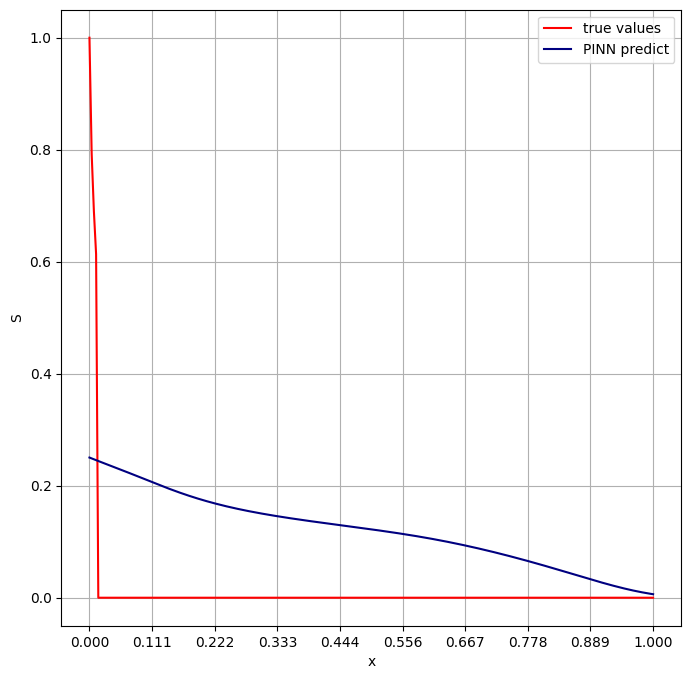

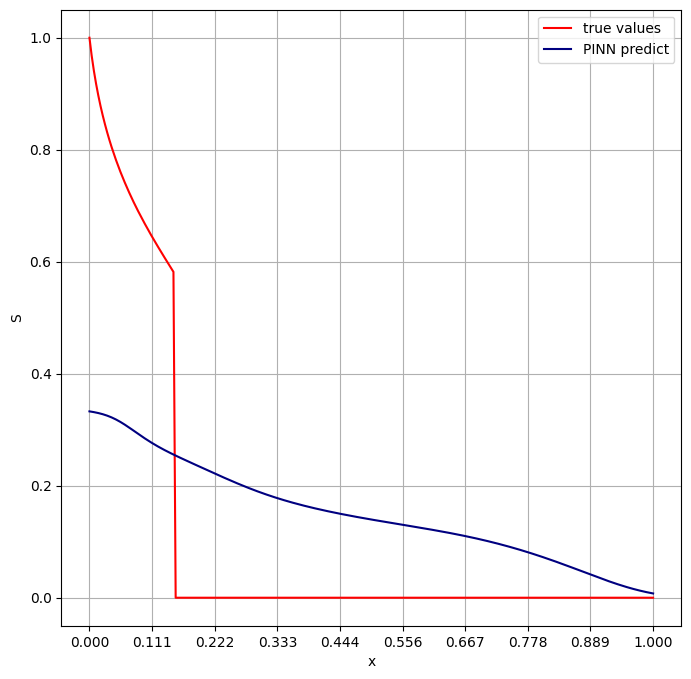

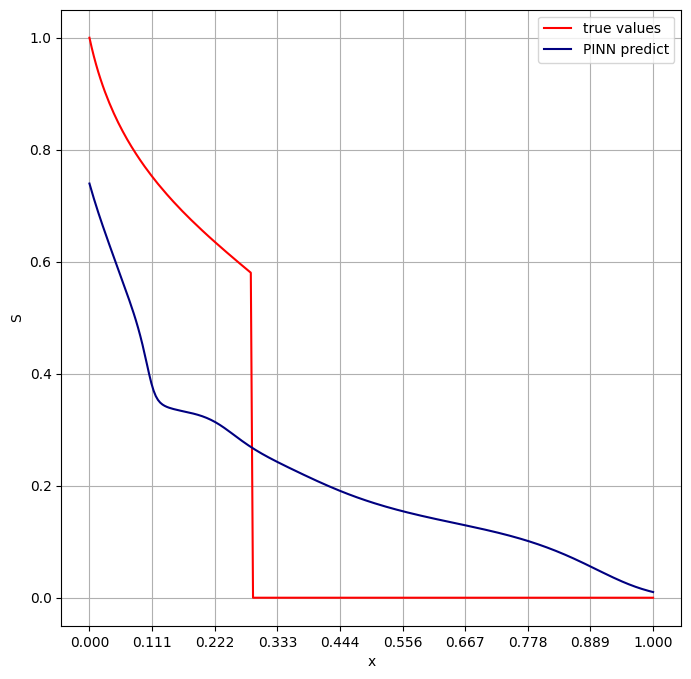

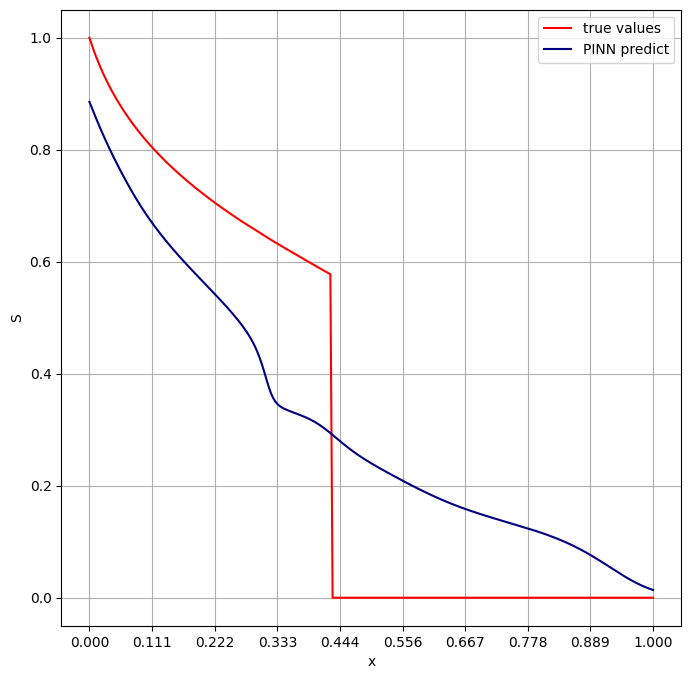

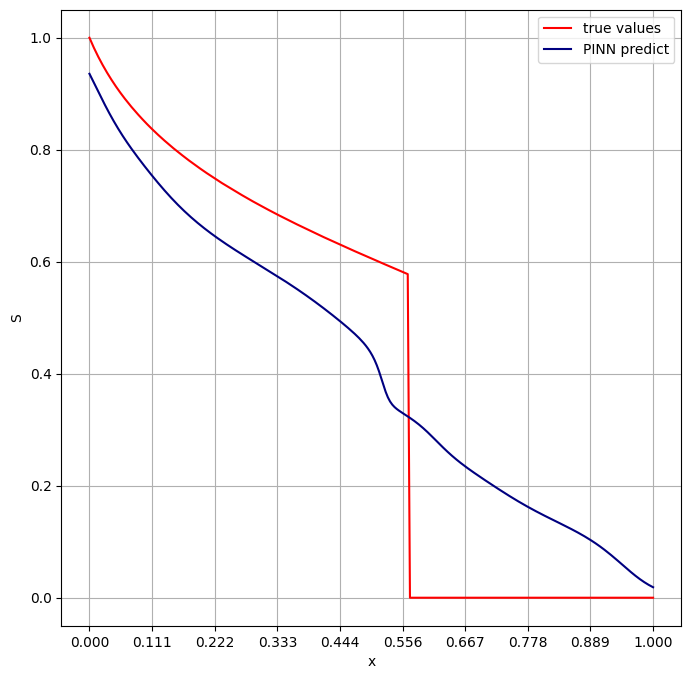

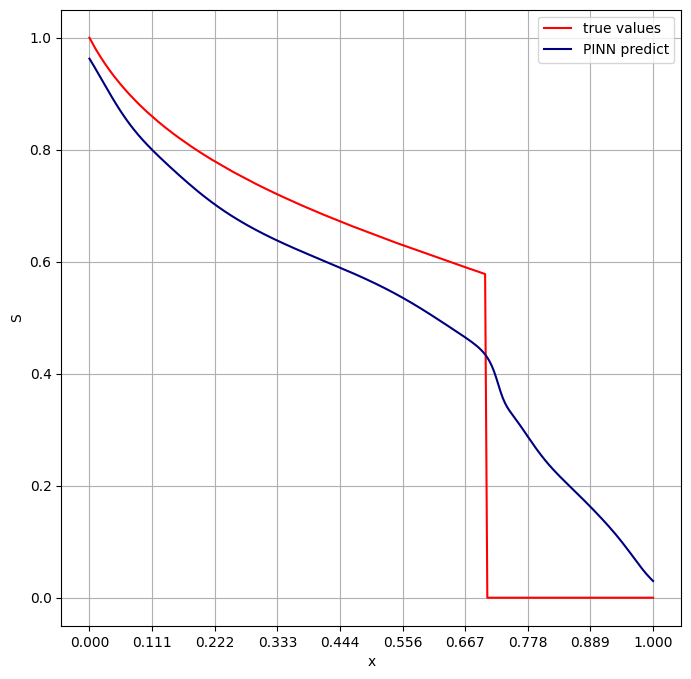

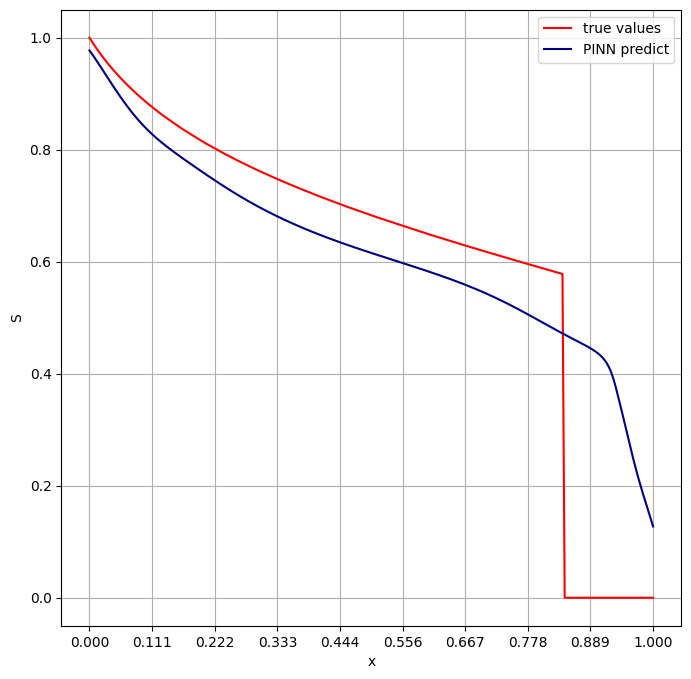

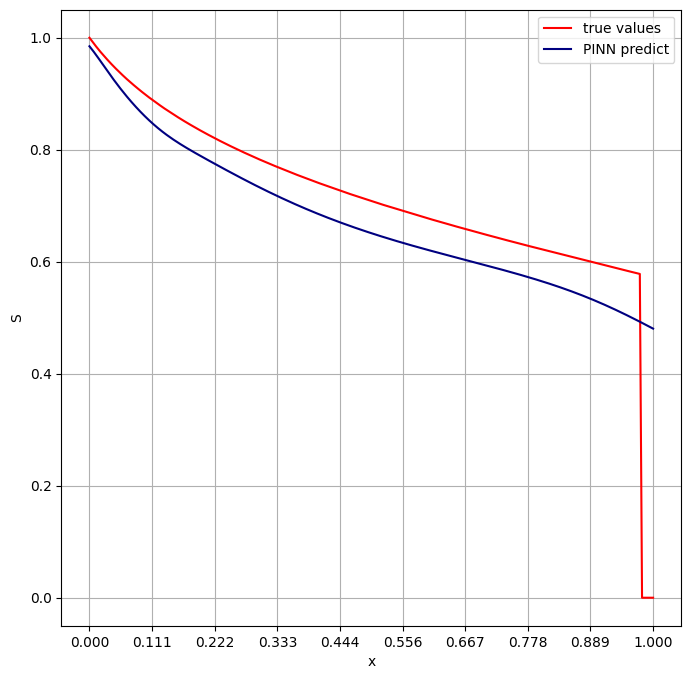

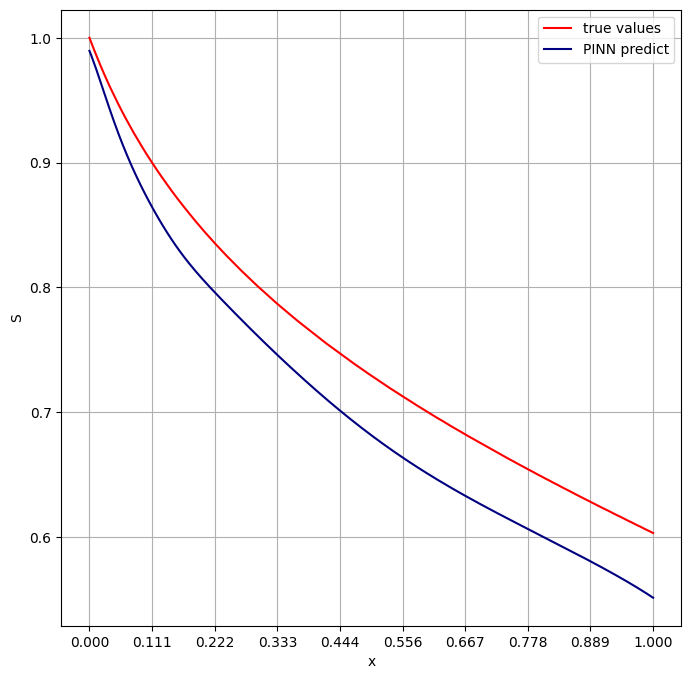

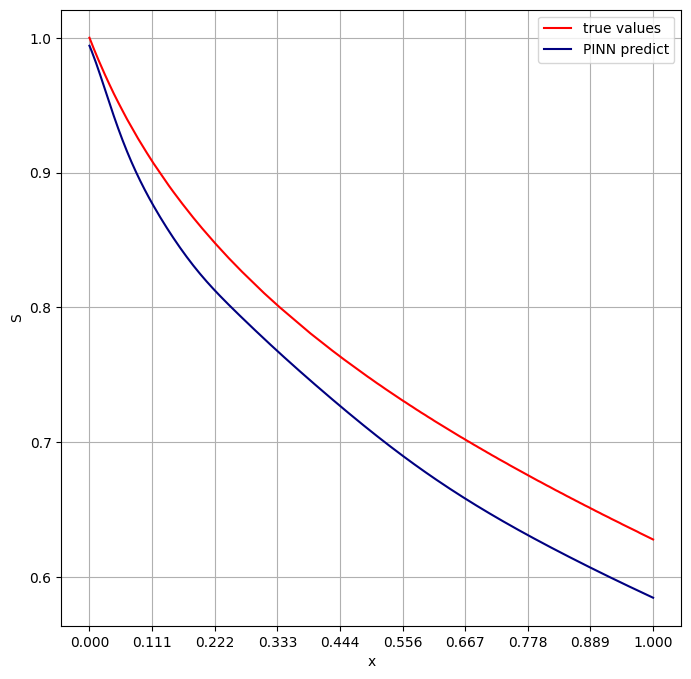

In [80]:

Uniq_time_array = []

Uniq_time_array.append(X_star[0,1])

for x in X_star[:,1]:
    if x not in Uniq_time_array:
        Uniq_time_array.append(x)

x_ticks = np.linspace(0,1,10)

for i in range(1,len(Uniq_time_array[:-1]),10):

    S_array = []
    X_array = []
    S_true_array = []
    check_time = Uniq_time_array[i]
    count = 0

    t = X_star[0,1]

    while t != check_time:
        count = count + 1
        t = X_star[count,1]
    

    while check_time == Uniq_time_array[i]:
        X_array.append(X_star[count,0])
        S_array.append(u_pred[count])
        S_true_array.append(u_star[count])
        count = count + 1
        check_time = X_star[count,1]
        
    
    fig = plt.figure(figsize=(8,8))
    plt.plot(X_array,S_true_array,"-r", label = 'true values')
    plt.plot(X_array,S_array, color='navy', label = 'PINN predict')
    plt.xlabel('x')
    plt.ylabel('S')
    plt.legend()
    #plt.title('t='+str((Uniq_time_array[i])))
    plt.grid()
    plt.xticks(x_ticks)